# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


D:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:
import os
os.environ['MKL_NUM_THREADS'] = '1'

In [5]:
recommender = MainRecommender(data_train_lvl_1)

In [6]:
recommender.get_als_recommendations(2375, N=200)

[899624,
 923746,
 1044078,
 871756,
 844179,
 1004906,
 865456,
 845208,
 1046545,
 823704,
 823990,
 1037863,
 1068719,
 883932,
 910032,
 951590,
 863447,
 972931,
 12301839,
 841220,
 925862,
 870547,
 965766,
 1000753,
 896613,
 999714,
 1009770,
 1092937,
 965267,
 1134678,
 947858,
 828106,
 9835223,
 963971,
 1097458,
 1042942,
 1106523,
 999270,
 1130858,
 9836106,
 1131438,
 5569230,
 1051323,
 8090537,
 969932,
 938138,
 1041796,
 896862,
 827919,
 949965,
 982790,
 957741,
 850925,
 902172,
 1026984,
 5585510,
 1046689,
 8065410,
 1081177,
 871611,
 998373,
 12810391,
 981521,
 1022827,
 1044068,
 825343,
 999858,
 1039126,
 1103691,
 843306,
 880150,
 962229,
 898068,
 956599,
 912137,
 835300,
 1043590,
 832678,
 12731544,
 8090521,
 1069979,
 973374,
 837304,
 850102,
 948650,
 944534,
 9832469,
 874972,
 853221,
 1036249,
 1036347,
 995896,
 995816,
 963727,
 1025535,
 1110292,
 895166,
 12731432,
 873902,
 825170,
 954363,
 6534480,
 830304,
 1005935,
 1094833,
 104290

In [7]:
recommender.get_own_recommendations(2375, N=200)

[1036501,
 1079023,
 1085983,
 907099,
 910439,
 1027642,
 1005935,
 894360,
 1046689,
 847066,
 828370,
 969932,
 1003616,
 884694,
 999104,
 1097422,
 9527066,
 950935,
 835300,
 1015474,
 1072685,
 989069,
 974265,
 840640,
 945652,
 940996,
 9527494,
 1125219,
 827667,
 986021,
 982955,
 1131382,
 846652,
 10308345,
 873160,
 9526673,
 1000707,
 938139,
 890719,
 1038692,
 916487,
 1006878,
 971811,
 1035842,
 998373,
 5567194,
 980433,
 7441873,
 1115098,
 1021715,
 1070803,
 960791,
 1022340,
 965963,
 983078,
 973374,
 6391532,
 1068451,
 1068715,
 886941,
 929751,
 5570048,
 947858,
 834631,
 996269,
 938622,
 1115553,
 1033046,
 8160430,
 1082454,
 913806,
 982833,
 1023815,
 847901,
 857006,
 1056492,
 853522,
 1004945,
 1078652,
 1044068,
 887618,
 1092885,
 850102,
 841309,
 874643,
 900802,
 13945141,
 919427,
 938138,
 1101174,
 1014238,
 1092692,
 932675,
 1018740,
 937343,
 7169034,
 951221,
 956599,
 5570408,
 1044805,
 999730,
 995211,
 1138467,
 984715,
 974306,
 909

In [8]:
recommender.get_similar_items_recommendation(2375, N=200)

[868764,
 1046545,
 845208,
 9527160,
 1106523,
 1074333,
 1042907,
 1133018,
 918335,
 1080155,
 9527161,
 9297136,
 945662,
 961554,
 923746,
 1134678,
 1002558,
 873160,
 1043751,
 999104,
 1117514,
 899844,
 899624,
 883068,
 1120362,
 879755,
 5568378,
 906923,
 878996,
 951590,
 871611,
 1037863,
 828106,
 866871,
 1070702,
 1027090,
 1096317,
 844179,
 825343,
 925178,
 1097422,
 9835223,
 899624,
 1018740,
 863885,
 1036325,
 1059473,
 1076875,
 913745,
 957951,
 969932,
 961554,
 948650,
 1092885,
 882247,
 1054262,
 5570408,
 8090537,
 852065,
 899459,
 954216,
 913671,
 877498,
 896862,
 989935,
 882190,
 12262778,
 901205,
 1038746,
 6602440,
 1095700,
 12301839,
 1075470,
 905436,
 897295,
 1119860,
 964133,
 1105488,
 825343,
 843306,
 991999,
 1117393,
 1026118,
 828106,
 844179,
 897954,
 942341,
 987724,
 945998,
 1123842,
 969945,
 1096036,
 962568,
 888532,
 873902,
 1079338,
 916487,
 846986,
 1131382,
 1069334,
 960732,
 1110843,
 1053754,
 1068719,
 1079067,
 1026

In [9]:
recommender.get_similar_users_recommendation(2, N=200)

[1008288,
 1125601,
 1046689,
 1082990,
 1031316,
 1018339,
 845193,
 1085983,
 12262832,
 825882,
 841365,
 6391349,
 8019681,
 9881593,
 9802981,
 1117219,
 1053329,
 1082990,
 1063739,
 12262832,
 1037840,
 849100,
 904241,
 1076580,
 1058930,
 865026,
 1118878,
 5568489,
 1011926,
 1118946,
 1008288,
 1099164,
 10150078,
 1118878,
 888586,
 1135044,
 958067,
 1087287,
 962266,
 945652,
 879734,
 911017,
 1065979,
 894360,
 8090539,
 977798,
 873550,
 1080429,
 1133850,
 1076580,
 5568072,
 832001,
 5563693,
 1087287,
 7410336,
 1005849,
 997987,
 1082990,
 1093603,
 1017195,
 962266,
 870559,
 862535,
 867138,
 862488,
 1075368,
 915493,
 888104,
 1044259,
 1095227,
 1036753,
 8090956,
 5570882,
 7168619,
 1073150,
 1028891,
 1010190,
 935578,
 1092588,
 6632283,
 5570882,
 1018050,
 899682,
 10344585,
 1102003,
 1093603,
 1010190,
 1076580,
 1088147,
 1101653,
 5568732,
 855718,
 9419422,
 1054402,
 974548,
 870559,
 1036753,
 1056212,
 1080429,
 1115577,
 875392,
 981591,
 557068

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]

In [12]:
result_lvl_1['als_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))

In [13]:
result_lvl_1.head()

,user_id,actual,als_recs
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1082212, 5569374, 1094924, 6423911, 885290, 1..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 1004906, 10150194, 880150, 5569230, 9..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[902172, 821741, 6391541, 891423, 846550, 7169..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[863632, 1024306, 1042616, 999250, 1051516, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[853643, 1054424, 1003188, 1059236, 1130111, 1..."


In [14]:
result_lvl_1['own_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [15]:
result_lvl_1['similar_item_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=200))

In [16]:
result_lvl_1['similar_users_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=200))

In [25]:
recall_at_200_own_recs = result_lvl_1.apply(lambda row: recall_at_k(row['own_recs'], row['actual'], k=200), axis=1).mean()
recall_at_200_own_recs

0.19047666994765725

In [26]:
recall_at_200_similar_items_recs = result_lvl_1.apply(lambda row: recall_at_k(row['similar_item_recs'], row['actual'], k=200), axis=1).mean()
recall_at_200_similar_items_recs

0.11335706544631464

In [27]:
recall_at_200_similar_users_recs = result_lvl_1.apply(lambda row: recall_at_k(row['similar_users_recs'], row['actual'], k=200), axis=1).mean()
recall_at_200_similar_users_recs

0.023758834125753768

In [28]:
recall_at_200_als_recs = result_lvl_1.apply(lambda row: recall_at_k(row['als_recs'], row['actual'], k=200), axis=1).mean()
recall_at_200_als_recs

0.1341765609441472

самый высокий recall@200 получился у own_recommendations.

In [29]:
recall_list = []
for k in range(20, 201, 10):
    recall_list.append(result_lvl_1.apply(lambda row: recall_at_k(row['als_recs'], row['actual'], k=k), axis=1).mean())

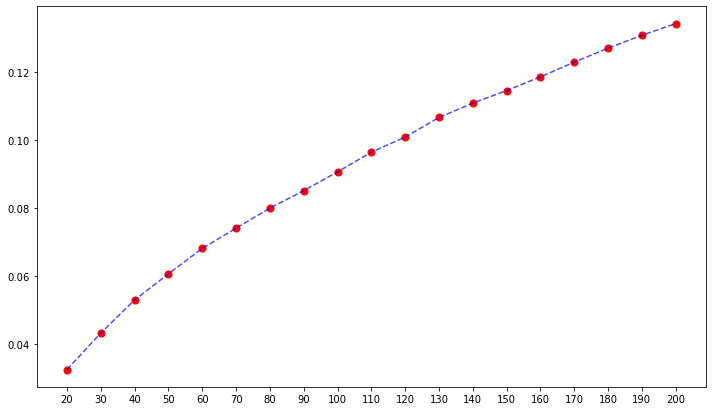

In [37]:
plt.figure(figsize=(12,7))
plt.plot(list(range(20, 201, 10)), recall_list, color='blue', linestyle='dashed', alpha=0.7)
plt.scatter(list(range(20, 201, 10)), recall_list, color='red', s=50)
plt.xticks(list(range(20, 201, 10)))
plt.show()

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [149]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))

In [150]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,1042942,1
0,2070,923746,1
0,2070,1107553,1
0,2070,908531,1


In [390]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [391]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [392]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

В качестве фичей для юзера возьмем средний чек:

In [393]:
mean_check_by_user = data.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index().\
                                    groupby('user_id')['sales_value'].mean().reset_index()

In [394]:
targets_lvl_2 = targets_lvl_2.merge(mean_check_by_user, on='user_id', how='left').rename(columns={'sales_value': 'mean_check'})
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937
2,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937
4,2070,865456,1.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937


In [395]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

Кол-во покупок по категориям:

In [396]:
item_user_categories = data[['user_id', 'item_id', 'quantity']].merge(item_features[['item_id', 'department']], on='item_id', how='left')
item_user_categories.head()

,user_id,item_id,quantity,department
0,2375,1004906,1,PRODUCE
1,2375,1033142,1,PRODUCE
2,2375,1036325,1,PRODUCE
3,2375,1082185,1,PRODUCE
4,2375,8160430,1,PRODUCE


In [397]:
qnty_by_department = item_user_categories.groupby(['user_id', 'department'])['quantity'].sum().reset_index()
qnty_by_department.head()

,user_id,department,quantity
0,1,,0
1,1,DELI,58
2,1,DRUG GM,176
3,1,FLORAL,1
4,1,GROCERY,1229


In [398]:
targets_lvl_2 = targets_lvl_2.merge(qnty_by_department, on=['user_id', 'department'], how='left').rename(columns={'quantity': 'qnty_by_department'})
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,qnty_by_department
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0
2,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0
4,2070,865456,1.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0


In [399]:
targets_lvl_2['qnty_by_department'] = targets_lvl_2['qnty_by_department'].fillna(0)
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

В качестве фичей для айтемов возьмем среднюю стоимость:

In [400]:
items_cost = data.groupby('item_id')['sales_value'].mean().reset_index().rename(columns={'sales_value': 'item_cost'})

In [401]:
targets_lvl_2 = targets_lvl_2.merge(items_cost, on='item_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,qnty_by_department,item_cost
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.310415
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.579829
2,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.188556
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.742008
4,2070,865456,1.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.197517


In [402]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

Кол-во покупок в неделю:

In [403]:
qnty_by_week = data.groupby(['item_id', 'week_no'])['quantity'].sum().reset_index().\
                    groupby('item_id')['quantity'].mean().reset_index().rename(columns={'quantity': 'buys_per_week'})
qnty_by_week.head()

,item_id,buys_per_week
0,25671,2.0
1,26081,1.0
2,26093,1.0
3,26190,1.0
4,26355,2.0


In [404]:
targets_lvl_2 = targets_lvl_2.merge(qnty_by_week, on='item_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,qnty_by_department,item_cost,buys_per_week
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.310415,3.764706
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.579829,55.694737
2,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.188556,10.150538
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.742008,70.515789
4,2070,865456,1.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.197517,10.406593


In [405]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

В качестве фичей юзер-айтем возьмем (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id):

In [406]:
item_users_costs = data[['user_id', 'item_id', 'sales_value']].merge(item_features[['item_id', 'commodity_desc']], on='item_id', how='left')

In [407]:
mean_prices_by_department = item_users_costs.groupby('commodity_desc')['sales_value'].mean().reset_index()

In [408]:
mean_prices_by_department = mean_prices_by_department.rename(columns={'sales_value': 'mean_price_by_comm'})

In [409]:
item_users_costs = item_users_costs.groupby(['user_id', 'item_id', 'commodity_desc'])['sales_value'].mean().reset_index()

In [410]:
item_users_costs = item_users_costs.merge(mean_prices_by_department, on='commodity_desc', how='left')

In [411]:
item_users_costs.head()

,user_id,item_id,commodity_desc,sales_value,mean_price_by_comm
0,1,819312,IN-STORE PHOTOFINISHING,5.67,8.916523
1,1,820165,CITRUS,1.75,2.107157
2,1,821815,DRY SAUCES/GRAVY,3.38,1.546665
3,1,821867,BAKING NEEDS,0.69,2.104134
4,1,823721,CHEESE,2.99,2.535740


In [412]:
item_users_costs['price_diff'] = item_users_costs['mean_price_by_comm'] - item_users_costs['sales_value']

In [413]:
item_users_costs = item_users_costs.drop(['sales_value', 'mean_price_by_comm'], axis=1)

In [414]:
item_users_costs.shape

(1314372, 4)

In [415]:
targets_lvl_2 = targets_lvl_2.merge(item_users_costs, on=['user_id', 'item_id', 'commodity_desc'], how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,qnty_by_department,item_cost,buys_per_week,price_diff
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.310415,3.764706,-0.917510
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.579829,55.694737,-0.872706
2,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.188556,10.150538,1.779924
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.742008,70.515789,-0.224537
4,2070,865456,1.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,...,50-74K,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.197517,10.406593,-1.454260


In [416]:
targets_lvl_2['price_diff'] = targets_lvl_2['price_diff'].fillna(0)

In [417]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

In [418]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


(Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю):

In [419]:
qnty_item_user = data[['user_id', 'item_id', 'quantity', 'week_no']].merge(item_features[['item_id', 'commodity_desc']], on='item_id', how='left')

In [420]:
mean_qnty_by_comm = qnty_item_user.groupby(['commodity_desc', 'week_no'])['quantity'].sum().reset_index().\
                                    groupby('commodity_desc')['quantity'].mean().reset_index()
mean_qnty_by_comm.head()

,commodity_desc,quantity
0,,0.000000
1,(CORP USE ONLY),1.644444
2,ADULT INCONTINENCE,6.180851
3,AIR CARE,67.147368
4,ANALGESICS,52.168421


In [421]:
mean_qnty_by_comm_by_user = qnty_item_user.groupby(['commodity_desc', 'week_no', 'user_id'])['quantity'].sum().reset_index().\
                                    groupby(['user_id', 'commodity_desc'])['quantity'].mean().reset_index()
mean_qnty_by_comm_by_user.head()

,user_id,commodity_desc,quantity
0,1,,0.000000
1,1,AIR CARE,1.692308
2,1,ANALGESICS,1.000000
3,1,APPLES,1.000000
4,1,BACON,1.000000


In [422]:
mean_qnty_by_comm_by_user = mean_qnty_by_comm_by_user.rename(columns={'quantity': 'qnty_by_user'})

In [423]:
mean_qnty_by_comm_by_user = mean_qnty_by_comm_by_user.merge(mean_qnty_by_comm, on='commodity_desc', how='left')

In [424]:
mean_qnty_by_comm_by_user['qnty_diff_week'] = mean_qnty_by_comm_by_user['qnty_by_user'] - mean_qnty_by_comm_by_user['quantity']

In [425]:
mean_qnty_by_comm_by_user.head()

,user_id,commodity_desc,qnty_by_user,quantity,qnty_diff_week
0,1,,0.000000,0.000000,0.000000
1,1,AIR CARE,1.692308,67.147368,-65.455061
2,1,ANALGESICS,1.000000,52.168421,-51.168421
3,1,APPLES,1.000000,165.978947,-164.978947
4,1,BACON,1.000000,155.263158,-154.263158


In [426]:
mean_qnty_by_comm_by_user.drop(['qnty_by_user', 'quantity'], axis=1, inplace=True)

In [427]:
mean_qnty_by_comm_by_user[mean_qnty_by_comm_by_user['commodity_desc'] == 'FRZN ICE'].loc[mean_qnty_by_comm_by_user['user_id']==2070]

,user_id,commodity_desc,qnty_diff_week


In [428]:
data.loc[data['user_id']==2070]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
134919,2070,28081177271,92,842930,3,5.00,311,-1.57,2314,14,0.0,0.0
134920,2070,28081177271,92,965756,1,4.99,311,0.00,2314,14,0.0,0.0
134921,2070,28081177271,92,1019940,1,1.29,311,0.00,2314,14,0.0,0.0
134922,2070,28081177271,92,1106198,1,2.69,311,0.00,2314,14,0.0,0.0
134923,2070,28081177271,92,6979317,3,10.00,311,0.00,2314,14,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2393324,2070,41652855193,663,13986629,1,2.99,311,-0.70,949,95,0.0,0.0
2393325,2070,41652855193,663,13987340,1,2.99,311,-0.70,949,95,0.0,0.0
2393326,2070,41652855193,663,14025676,1,2.39,311,0.00,949,95,-0.4,-0.4
2393327,2070,41652855193,663,15452592,1,3.09,311,0.00,949,95,-0.5,-0.5


In [429]:
targets_lvl_2 = targets_lvl_2.merge(mean_qnty_by_comm_by_user, on=['user_id', 'commodity_desc'], how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,qnty_by_department,item_cost,buys_per_week,price_diff,qnty_diff_week
0,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.310415,3.764706,-0.917510,-298.136842
1,2070,923746,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,18 CT,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.579829,55.694737,-0.872706,-331.642468
2,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.188556,10.150538,1.779924,-1565.728479
3,2070,908531,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,1.742008,70.515789,-0.224537,-1121.191014
4,2070,865456,1.0,317,GROCERY,National,CHEESE,LOAF CHEESE,L 2 LB,45-54,...,Unknown,Unknown,1,None/Unknown,12.92937,2216.0,4.197517,10.406593,-1.454260,-933.019298


In [430]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

In [431]:
na_values = targets_lvl_2.loc[targets_lvl_2['qnty_diff_week'].isnull()][['commodity_desc', 'qnty_diff_week']]
na_values = na_values.merge(mean_qnty_by_comm, on='commodity_desc', how='left')
na_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50528 entries, 0 to 50527
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   commodity_desc  50528 non-null  object 
 1   qnty_diff_week  0 non-null      float64
 2   quantity        50528 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB


In [432]:
na_values['qnty_diff_week'] = -na_values['quantity']
na_values.head()

,commodity_desc,qnty_diff_week,quantity
0,FRZN ICE,-29.663158,29.663158
1,FRZN ICE,-29.663158,29.663158
2,SALADS/DIPS,-81.336842,81.336842
3,SALADS/DIPS,-81.336842,81.336842
4,SALADS/DIPS,-81.336842,81.336842


In [433]:
na_values = na_values.groupby('commodity_desc').mean().reset_index()
na_values.head()

,commodity_desc,qnty_diff_week,quantity
0,AIR CARE,-67.147368,67.147368
1,ANALGESICS,-52.168421,52.168421
2,ANTACIDS,-21.265957,21.265957
3,APPLES,-165.978947,165.978947
4,AUTOMOTIVE PRODUCTS,-11.715789,11.715789


In [434]:
targets_lvl_2[targets_lvl_2['qnty_diff_week'].isnull()]

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,qnty_by_department,item_cost,buys_per_week,price_diff,qnty_diff_week
61,2070,957951,0.0,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,45-54,...,Unknown,Unknown,1,None/Unknown,12.929370,2216.0,4.914476,10.107527,0.0,NaN
84,2070,1102959,0.0,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,7 LB,45-54,...,Unknown,Unknown,1,None/Unknown,12.929370,2216.0,1.646466,12.178947,0.0,NaN
104,2070,7025202,0.0,69,DELI,Private,SALADS/DIPS,PASTA/GRAIN SALADS - PREPACK,3 LB,45-54,...,Unknown,Unknown,1,None/Unknown,12.929370,24.0,4.248325,2.729730,0.0,NaN
192,2070,7024927,0.0,69,DELI,Private,SALADS/DIPS,VEGETABLE SALADS - PREPACK,3 LB,45-54,...,Unknown,Unknown,1,None/Unknown,12.929370,24.0,4.129925,1.985714,0.0,NaN
216,2070,7025496,0.0,69,DELI,Private,SALADS/DIPS,VEGETABLE SALADS - PREPACK,3 LB,45-54,...,Unknown,Unknown,1,None/Unknown,12.929370,24.0,4.341156,2.575342,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437730,1745,852015,0.0,1420,DRUG GM,National,INFANT FORMULA,INFANT FORMULA SOY BASE,12.9 OZ,45-54,...,Unknown,Single Male,2,None/Unknown,20.311933,53.0,17.307317,2.826087,0.0,NaN
437733,1745,7025496,0.0,69,DELI,Private,SALADS/DIPS,VEGETABLE SALADS - PREPACK,3 LB,45-54,...,Unknown,Single Male,2,None/Unknown,20.311933,9.0,4.341156,2.575342,0.0,NaN
437740,1745,1135681,0.0,1600,DRUG GM,National,BABY FOODS,BABY SPRING WATERS,,45-54,...,Unknown,Single Male,2,None/Unknown,20.311933,53.0,2.093521,4.023256,0.0,NaN
437741,1745,13189919,0.0,1266,GROCERY,National,MOLASSES/SYRUP/PANCAKE MIXS,PANCAKE MIXES,32 OZ,45-54,...,Unknown,Single Male,2,None/Unknown,20.311933,888.0,2.468941,2.288889,0.0,NaN


In [436]:
targets_lvl_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437748 entries, 0 to 437747
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               437748 non-null  int64  
 1   item_id               437748 non-null  int64  
 2   target                437748 non-null  float64
 3   manufacturer          437748 non-null  int64  
 4   department            437748 non-null  object 
 5   brand                 437748 non-null  object 
 6   commodity_desc        437748 non-null  object 
 7   sub_commodity_desc    437748 non-null  object 
 8   curr_size_of_product  437748 non-null  object 
 9   age_desc              162841 non-null  object 
 10  marital_status_code   162841 non-null  object 
 11  income_desc           162841 non-null  object 
 12  homeowner_desc        162841 non-null  object 
 13  hh_comp_desc          162841 non-null  object 
 14  household_size_desc   162841 non-null  object 
 15  

In [438]:
targets_lvl_2['qnty_diff_week'] = targets_lvl_2['qnty_diff_week'].fillna(min(targets_lvl_2['qnty_diff_week']))

In [440]:
from catboost import CatBoostClassifier

In [441]:
cat_feats = ['department', 'brand', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', 'age_desc', 
            'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc']

In [444]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [449]:
X_train = X_train.fillna('')

In [451]:
%%time
catboost = CatBoostClassifier(n_estimators=300, max_depth=7, cat_features=cat_feats)
catboost.fit(X_train, y_train)
preds = catboost.predict(X_train)

Learning rate set to 0.417077
0:	learn: 0.2092105	total: 336ms	remaining: 1m 40s
1:	learn: 0.1568529	total: 696ms	remaining: 1m 43s
2:	learn: 0.1466497	total: 1.02s	remaining: 1m 40s
3:	learn: 0.1427778	total: 1.29s	remaining: 1m 35s
4:	learn: 0.1412324	total: 1.59s	remaining: 1m 33s
5:	learn: 0.1395442	total: 1.9s	remaining: 1m 33s
6:	learn: 0.1383190	total: 2.21s	remaining: 1m 32s
7:	learn: 0.1367514	total: 2.55s	remaining: 1m 33s
8:	learn: 0.1362264	total: 2.86s	remaining: 1m 32s
9:	learn: 0.1355433	total: 3.19s	remaining: 1m 32s
10:	learn: 0.1348819	total: 3.5s	remaining: 1m 32s
11:	learn: 0.1334261	total: 3.82s	remaining: 1m 31s
12:	learn: 0.1330899	total: 4s	remaining: 1m 28s
13:	learn: 0.1326595	total: 4.31s	remaining: 1m 28s
14:	learn: 0.1325029	total: 4.47s	remaining: 1m 25s
15:	learn: 0.1320129	total: 4.8s	remaining: 1m 25s
16:	learn: 0.1303628	total: 5.13s	remaining: 1m 25s
17:	learn: 0.1299982	total: 5.46s	remaining: 1m 25s
18:	learn: 0.1297883	total: 5.78s	remaining: 1m 25

159:	learn: 0.1087730	total: 50.2s	remaining: 43.9s
160:	learn: 0.1086648	total: 50.5s	remaining: 43.6s
161:	learn: 0.1085151	total: 50.8s	remaining: 43.3s
162:	learn: 0.1084174	total: 51.1s	remaining: 42.9s
163:	learn: 0.1083145	total: 51.4s	remaining: 42.6s
164:	learn: 0.1082683	total: 51.7s	remaining: 42.3s
165:	learn: 0.1081346	total: 52s	remaining: 42s
166:	learn: 0.1080886	total: 52.3s	remaining: 41.7s
167:	learn: 0.1079876	total: 52.7s	remaining: 41.4s
168:	learn: 0.1078495	total: 52.9s	remaining: 41s
169:	learn: 0.1077182	total: 53.3s	remaining: 40.7s
170:	learn: 0.1076242	total: 53.6s	remaining: 40.4s
171:	learn: 0.1075379	total: 53.9s	remaining: 40.1s
172:	learn: 0.1074992	total: 54.2s	remaining: 39.8s
173:	learn: 0.1074161	total: 54.5s	remaining: 39.5s
174:	learn: 0.1073246	total: 54.8s	remaining: 39.1s
175:	learn: 0.1073024	total: 55.1s	remaining: 38.8s
176:	learn: 0.1072959	total: 55.4s	remaining: 38.5s
177:	learn: 0.1072453	total: 55.7s	remaining: 38.2s
178:	learn: 0.1071

In [453]:
preds = catboost.predict_proba(X_train)

In [455]:
preds = preds[:, 1]

In [456]:
targets_lvl_2['predictions']=preds

In [459]:
sorted_targets = targets_lvl_2.sort_values(['user_id', 'predictions'], ascending=False)

In [464]:
user_id_list=[]
recs = []
for user_id in sorted_targets['user_id'].unique():
    user_id_list.append(user_id)
    recs.append(sorted_targets[sorted_targets['user_id']==user_id]['item_id'][:5].tolist())
result=pd.DataFrame({'user_id':user_id_list, 'catboos_recs': recs})

In [465]:
result_lvl_1 = result_lvl_1.merge(result, on='user_id', how='inner')

In [466]:
precision_at_5_als_recs = result_lvl_1.apply(lambda row: precision_at_k(row['als_recs'], row['actual'], k=5), axis=1).mean()
precision_at_5_als_recs

0.11463074779377519

In [467]:
precision_at_5_catboost_recs = result_lvl_1.apply(lambda row: precision_at_k(row['catboos_recs'], row['actual'], k=5), axis=1).mean()
precision_at_5_catboost_recs

0.3740826753367401

precision@5 значительно увеличился после применения второй модели.

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)